# Solutions to Tensor basics

Here, we cover some very basic concepts of tensor networks:

- how to represent tensors numerically, and
- what the basic operations are that we need for tensors

For these (toy code) exercises will use the python [numpy](https://numpy.org/doc/stable/user/quickstart.html) librabry for simplicity. For production MPS code, you should eventually switch to a more generic library, e.g., [TeNPy](https://github.com/tenpy/tenpy), which provide a more powerfull class for representing tensors - this allows to make use of block-sparseness implied by symmetries and helps with index bookkeeping.

In [1]:
import numpy as np

For later use, let us also import matplotlib and set some cosmetic display options.

In [2]:
import matplotlib.pyplot as plt

np.set_printoptions(precision=5, suppress=True, linewidth=100, threshold=50)
plt.rcParams['figure.dpi'] = 150

## Initializing tensors in numpy

From a mathematical point of view, tensors are multi-linear function between vector spaces.
From a numerical point of view, however, tensors are just collections of numbers arranged in a multi-dimensional grid, with element-wise addition and tensordot contractions over one or multiple legs.

In this set of toycodes, we represent tensors directly as numpy arrays. 
The following examples demonstrate different ways to initialize tensors, here for the usual `2x2` Pauli matrices:

In [3]:
# np.eye = identity matrix of given dimension 2
Id = np.eye(2)  
Id

array([[1., 0.],
       [0., 1.]])

In [4]:
# specify each element 
X = np.array([[0, 1.], [1., 0.]])  
X

array([[0., 1.],
       [1., 0.]])

In [5]:
# initialize empty matrix of dimensions 2x2
Y = np.zeros([2, 2], dtype=np.complex_) 
# and explicitly set non-zero entries
Y[0, 1] = -1.j  # j = imaginary unit
Y[1, 0] = 1.j
Y

array([[ 0.+0.j, -0.-1.j],
       [ 0.+1.j,  0.+0.j]])

In [6]:
# only specify the diagonal of a matrix
Z = np.diag([1., -1.]) 
Z

array([[ 1.,  0.],
       [ 0., -1.]])

They are all simple `2x2` matrices, as we can see by checking the `shape`. Only the `Y` matrix has complex data type (`dtype`):

In [7]:
for M in [Id, X, Y, Z]:
    print(M.shape, M.dtype)

(2, 2) float64
(2, 2) float64
(2, 2) complex128
(2, 2) float64


If we consider the Pauli matrices as spin-1/2 operators, we already implicitly assumed the basis to be $\lvert\uparrow\rangle, \lvert\downarrow\rangle$.

In [8]:
up = np.array([1., 0])
up

array([1., 0.])

In [9]:
down = np.array([0., 1.])
down

array([0., 1.])

## Element-wise operations
Element-wise addition of tensors and multiplication/division with scalars works as you might expect.

In [10]:
Z + 5 * X

array([[ 1.,  5.],
       [ 5., -1.]])

In [11]:
plus_x = (up + down) / np.sqrt(2)  # sqrt = square root
plus_x

array([0.70711, 0.70711])

Complex conjugation can be acchieved with `np.conj()` (or the `conj()` method of numpy arrays).

In [12]:
Y, np.conj(Y)

(array([[ 0.+0.j, -0.-1.j],
        [ 0.+1.j,  0.+0.j]]),
 array([[ 0.-0.j, -0.+1.j],
        [ 0.-1.j,  0.-0.j]]))

### Exercise: init `minus_x`

Initialize the state `minus_x`  $= \frac{1}{\sqrt{2}} \big( \lvert\uparrow \rangle - \lvert\downarrow\rangle \big)$

In [13]:
minus_x = (up - down) / np.sqrt(2)
minus_x

array([ 0.70711, -0.70711])

## Random vector
We can also define a small utility function to define a random (complex) vector pointing uniformly in any direction:

In [14]:
def random_vector(size, rng=np.random.default_rng(seed=1234)):
    """Return a normalized random vector of given shape pointing uniformly in any direction."""
    vector = rng.normal(size=size) + 1.j * rng.normal(size=size)
    return vector / np.linalg.norm(vector)

In [15]:
random_vector(3)

array([-0.45581+0.04337j,  0.01822+0.24548j,  0.21056+0.82791j])

## Leg label convention

Note that the order of tensor legs is important; and we need to keep track of it. 
Libraries like TeNPy can help with that bookkeeping, but here we keep it simple, and just write leg labels as comments in the code.

- For ket (vector) indices, we just use short identifiers, e.g. `i`, `j`, `i1`, `i2`, `vL`.
- For bra (dual) indices, we use an additional `*`, so calling `conj()` on a tensor toggles stars on all legs, and (square) operators should have       combinations of non-star and star labels.
- When contracting (examples further down), we indicate labels that are getting contacted over with square brackets.
- When grouping legs (examples further down), we combine labels in round brackets separated by dots, e.g. `(i.j)`.

In [16]:
plus_x # leg i
X # legs i i*
np.conj(plus_x) # leg i*

array([0.70711, 0.70711])

## More spins and legs, transpose and reshape to combine and split legs

When we have more than one spin, the Hilbert space is a an outer product of the local Hilbert spaces. In tensor network language, this corresponds to the fact that we can have one leg per spin.

For example, the singlet state $\frac{1}{\sqrt{2}}\big(\lvert \uparrow \rangle \otimes \lvert\downarrow \rangle - \lvert \downarrow \rangle \otimes \lvert\uparrow \rangle \big)$ on two spins could be represented by a two-leg tensor:

In [17]:
singlet = np.zeros([2, 2])  # legs i, j
singlet[0, 1] =  1./np.sqrt(2)
singlet[1, 0] = -1./np.sqrt(2)
singlet

array([[ 0.     ,  0.70711],
       [-0.70711,  0.     ]])

Alternatively, we can enumerate all possible combinations basis states (in lexiographical order),
in the case of two spins $\lvert\uparrow\uparrow\rangle, \lvert\uparrow\downarrow\rangle, \lvert\downarrow\uparrow\rangle, \lvert\downarrow\downarrow\rangle$, and use a single leg.

In other words, we can **combine** (or "**group**") the two legs to a single one.
For numpy arrays, this corresponds to a `reshape`, taking dimensions `d1` and `d2` of the individual legs to `d1 * d2`. It is merely a re-arranging of the tensors in a different grid, the entries are still the same:

In [18]:
singlet_group = np.reshape(singlet, [2*2]) # legs i j -> (i.j)
singlet_group

array([ 0.     ,  0.70711, -0.70711,  0.     ])

If we remember the order and dimensions of the combined legs, we can split it again by another reshape:

In [19]:
singlet_split = np.reshape(singlet_group, [2, 2]) #  legs (i.j) -> i j
singlet_split

array([[ 0.     ,  0.70711],
       [-0.70711,  0.     ]])

All of this generalizes to multiple legs, as long as we `transpose` legs to be combined next to each other.

For example, if we initialize a random vector $\theta_{a,b,c,d}$ and want to group legs as `a b c d -> (a.c) (b.d)`, we need to transpose first:

In [20]:
theta = random_vector([2, 3, 4, 5])  # legs a b c d
print(theta.shape)

(2, 3, 4, 5)


In [21]:
theta_group = np.reshape(np.transpose(theta, [0, 2, 1, 3]), # a b c d -> a c b d
                         [2*4, 3*5]) # a c b d -> (a.c) (b.d)
theta_group.shape

(8, 15)

In [22]:
theta_split = np.reshape(theta_group, [2, 4, 3, 5]) # (a.c) (b.d) -> a c b d

To get back to the original form, we need to transpose again:

In [23]:
np.linalg.norm(theta_split.transpose([0, 2, 1, 3])  # a c b d -> a b c d
               -theta)

0.0

### Exercise: reshape

Initialize a random vector `psi` with 6 legs of length 2, i.e. shape `(2, 2, 2, 2, 2, 2)`. 

Afterwards, reshape it into a matrix with each the first and last 3 legs combined.

*Tip*: In Python, you can use `[2]*5` to get a list `[2, ..., 2]` with 5 entries, 
and `2**5` $= 2^5$.

In [24]:
psi = random_vector([2]*6)  # i j k l m n 
psi.shape

(2, 2, 2, 2, 2, 2)

In [25]:
psi = np.reshape(psi, [2**3, 2**3]) # i j k l m n -> (i.j.k) (l.m.n)
psi.shape

(8, 8)

## Contractions with tensordot

The `np.tensordot` function performs contractions between two tensors along legs specified in the `axes` argument.
 
For example for the usual matrix-vector product $\hat{X} \lvert \uparrow\rangle$, we need to contract the second leg (index 1, since we start counting at 0) of `X` with the first (and only, index 0) leg of the `up` vector:

In [26]:
np.tensordot(X, up, axes=(1, 0)) # i [i*], [i] -> i

array([0., 1.])

Matrix multiplication looks similar, except that the second and the resulting tensor have one more leg:

In [27]:
np.tensordot(X, Y, axes=(1, 0))  # i [i*], [i] i* -> i i*

array([[0.+1.j, 0.+0.j],
       [0.+0.j, 0.-1.j]])

If we contract over all legs, we effectively perform an inner product and obtain a scalar:

In [28]:
np.tensordot(np.conj(plus_x), up, axes=(0, 0))  # [i*], [i] -> scalar

array(0.70711)

If we set `axes=0`, we obtain an outer product, e.g. if we want to get the operator `ZZ` $= Z_1 \otimes Z_2$ acting on two spins:

In [29]:
ZZ = np.tensordot(Z, Z, axes=0)  # i i*, j j* -> i i* j j*

For printing the result, let us group the in- and outgoing legs:

In [30]:
ZZ_g = np.transpose(ZZ, [0, 2, 1, 3])  # i i* j j* -> i j i* j*
ZZ_g = np.reshape(ZZ_g, [2*2, 2*2])    # i j i* j* -> (i.j) (i*.j*)
ZZ_g

array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  0.,  0.],
       [ 0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  1.]])

Finally, to contract multiple legs, we can pass two lists to `axes`:

In [31]:
ZZ # i i* j j*
Theta = random_vector([3, 2, 2, 4]) # a i j b
# contract i* of ZZ with 
ZZ_Theta = np.tensordot(ZZ, Theta, axes=([1, 3], [1, 2])) # i [i*] j [j*], a [i] [j] b -> i j a b
ZZ_Theta.shape

(2, 2, 3, 4)

### Exercise: contractions

- Contract the following expectation values using `tensordot` and check that you get the correct results:
  - `<plus_x|plus_x> =?= 1.`
  - `<plus_x|X|plus_x> =?= 1.`
  - `<plus_x|Z|plus_x> =?= 0.`
  

In [32]:
np.tensordot(np.conj(plus_x), plus_x, axes=[0, 0]) # [i*], [i] -> scalar

array(1.)

In [33]:
np.tensordot(np.conj(plus_x), # i*
             np.tensordot(X, plus_x, axes=[1, 0]),  # i [i*], [i] -> i
             axes=[0, 0])  # [i*], [i] -> scalar

array(1.)

In [34]:
np.tensordot(np.conj(plus_x), # i*
             np.tensordot(Z, plus_x, axes=[1, 0]),  # i [i*], [i] -> i
             axes=[0, 0])  # [i*], [i] -> scalar

array(-0.)


- Define the operator `h` $ = 4 \vec{S_1} \cdot \vec{S_2} = X_1 X_2 + Y_1 Y_2 + Z_1 Z_2 $ with 4 legs.


In [35]:
h = sum([np.tensordot(A, A, axes=0) for A in (X, Y, Z)])  # i i*, j j* 
h_g = np.transpose(h, [0, 2, 1, 3])  # i i* j j* -> i j i* j*
h_g = np.reshape(h_g, [2*2, 2*2])    # i j i* j* -> (i.j) (i*.j*)
np.real_if_close(h_g)

array([[ 1.,  0.,  0.,  0.],
       [ 0., -1.,  2.,  0.],
       [ 0.,  2., -1.,  0.],
       [ 0.,  0.,  0.,  1.]])

- Using `tensordot`, contract and check `<singlet|h|singlet> =?= -3`

In [36]:
h_singlet = np.tensordot(h, singlet, axes=([1, 3], [0, 1])) # i [i*] j [j*], [i] [j] -> i j
singlet_h_singlet = np.tensordot(np.conj(singlet), h_singlet, axes=([0, 1],[0, 1])) # [i*] [j*], [i] [j] -> scalar
singlet_h_singlet

array(-3.+0.j)

## Schmidt decomposition with SVD

The final tool we need are matrix operations, e.g., diagonalization, SVD or QR decomposition.
The idea is to just group legs to view the tensor as a matrix and then perform the corresponding operation.

The SVD is of particular importance because it eventually allows truncation. We can use it to calculate the entropy of the singlet:

In [37]:
# define singlet again, same as above
singlet = np.zeros([2, 2])  # i j
singlet[0, 1] =  1./np.sqrt(2)
singlet[1, 0] = -1./np.sqrt(2)
singlet

array([[ 0.     ,  0.70711],
       [-0.70711,  0.     ]])

In [38]:
A, S, B = np.linalg.svd(singlet, full_matrices=False) # i j -> i a, a, a j
S  # Schmidt values

array([0.70711, 0.70711])

We can also get the original tensor back by contracting `A` with `diag(S)` and `B`

In [39]:
contr = np.tensordot(np.diag(S), B, axes=[1, 0]) # a [a*], [a] j -> a j
contr = np.tensordot(A, contr, axes=[1, 0]) # i [a], [a] j -> i j
contr

array([[ 0.     ,  0.70711],
       [-0.70711,  0.     ]])

In [40]:
np.sum(S*S)  # normalization of the state implies sum(S*S) = 1

0.9999999999999998

In [41]:
def entropy(sing_vals):
    """Return von Neumann entropy."""
    # first discard small singular values, since 0 * log(0) -> 0
    # but log(0) not defined
    S = sing_vals[sing_vals>1.e-15]
    S2 = S*S
    S2 /= np.sum(S2)  # ensure normalization
    return - np.sum(S2 * np.log(S2))

In [42]:
entropy(S) / np.log(2)

1.0

## Truncation of Schmidt values

Let us now look at at spin system with `L=12` sites,
and consider a bipartition into the left 6 and the right 6 spins.

We already know how to get a random state with the left and right legs combined:

In [43]:
L = 12

In [44]:
psi_random = random_vector([2]*L)  # L legs
psi_random = np.reshape(psi_random, [2**(L//2), 2**(L//2)])  # combined legs (i0.i1...i{L/2-1}) (i{L/2}...i{L})

It turns out that random vectors are highly entangled with the entanglement entropy reaching nearly the maximal value $\frac{L}{2} \log(2)$:

In [45]:
A_random, S_random, B_random = np.linalg.svd(psi_random, full_matrices=False)
entropy(S_random) / np.log(2)

5.282231767294896

Ground states of local Hamiltonians behave very differently; in 1D the are law of the entanglement predicts a scaling constant in $L$.
(An exception are critical, gapless points where CFT predicts $S \propto \log(L)$.)

The following snippet uses exact diagonalization (and the Lanczos algorithm) to obtain the ground state of the transverse field ising model with $J=1, g=1.1$. (You can consider it a black bock for now - here we are interested in the properties of the state only.)

In [46]:
from tenpy_toycodes.tfi_exact import finite_gs_energy

energy, psi_ground_state = finite_gs_energy(L=L, J=1., g=1.1, return_psi=True)
psi_ground_state.shape

(4096,)

In [47]:
psi_ground_state = np.reshape(psi_ground_state, [2**(L//2), 2**(L//2)]) # combined left and right legs
A_ground_state, S_ground_state, B_ground_state = np.linalg.svd(psi_ground_state, full_matrices=False)
entropy(S_ground_state) / np.log(2)

0.44561532410538357

We can see this behaviour reflected in the decay of singular values:

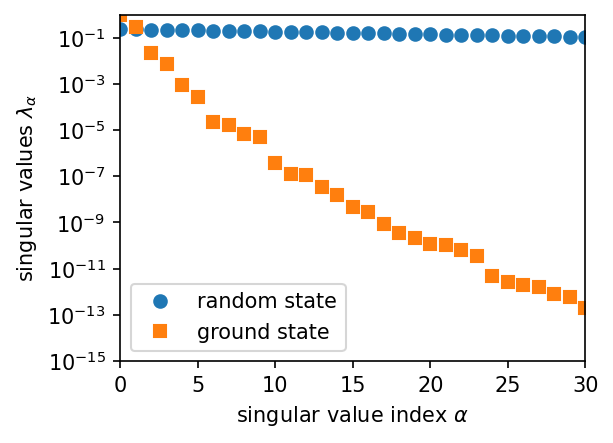

In [48]:
plt.figure(figsize=(4,3))
plt.plot(S_random, 'o', label='random state')
plt.plot(S_ground_state, 's', label='ground state')
plt.yscale('log')
plt.ylim(1.e-15, 1.)
plt.xlim(0, 30)
plt.xlabel(r'singular value index $\alpha$')
plt.ylabel(r'singular values $\lambda_\alpha$')
plt.legend(loc='lower left')

Ultimately, this decay of singular values for ground states is the reason why DMRG and MPS are so highly successfull.
It implies that we can truncate the state to much smaller bond dimension and still have large overlap with the initial state:

In [49]:
chi = 5
A_trunc = A_ground_state[:, :chi]
S_trunc = S_ground_state[:chi]
S_trunc = S_trunc / np.linalg.norm(S_trunc) # normalize to 1 again
B_trunc = B_ground_state[:chi, :]
psi_trunc = np.tensordot(np.diag(S_trunc), B_trunc, axes=[1, 0]) # a [a*], [a] j -> a j
psi_trunc = np.tensordot(A_trunc, psi_trunc, axes=[1, 0]) # i [a], [a] j -> i j
overlap = np.tensordot(np.conj(psi_trunc), psi_ground_state, axes=([0, 1], [0, 1])) # [i*] [j*], [i] [j]
err = 1. - np.abs(overlap)
err

4.065772185590788e-08

### Exercise: truncation

Play around with the "bond dimension" `chi` of Schmidt values kept above. What is the relation between the largest Schmidt value discared and the `err` above?

Try truncating the random state. What is the (absolute value of the) overlap if you keep 32 of the original 64 Schmidt values?

In [50]:
chi = 10
A_trunc = A_ground_state[:, :chi]
S_trunc = S_ground_state[:chi]
S_trunc = S_trunc / np.linalg.norm(S_trunc) # normalize to 1 again
B_trunc = B_ground_state[:chi, :]
psi_trunc = np.tensordot(np.diag(S_trunc), B_trunc, axes=[1, 0]) # a [a*], [a] j -> a j
psi_trunc = np.tensordot(A_trunc, psi_trunc, axes=[1, 0]) # i [a], [a] j -> i j
overlap = np.tensordot(np.conj(psi_trunc), psi_ground_state, axes=([0, 1], [0, 1])) # [i*] [j*], [i] [j]
err = 1. - np.abs(overlap)
err

9.037215420448774e-14

In [51]:
chi = 32
A_trunc = A_random[:, :chi]
S_trunc = S_random[:chi]
S_trunc = S_trunc / np.linalg.norm(S_trunc) # normalize to 1 again
B_trunc = B_random[:chi, :]
psi_trunc = np.tensordot(np.diag(S_trunc), B_trunc, axes=[1, 0]) # a [a*], [a] j -> a j
psi_trunc = np.tensordot(A_trunc, psi_trunc, axes=[1, 0]) # i [a], [a] j -> i j
overlap = np.tensordot(np.conj(psi_trunc), psi_random, axes=([0, 1], [0, 1])) # [i*] [j*], [i] [j]
np.abs(overlap)

0.9439061265039328

### Exercises (optional, if time left - for the experts, and those who want to become them)

- What is the maximal entropy that one can represent with $\chi$ Schmidt states? 
  (You can solve this analytically!)

  


- Find the half-chain entanglement entropy of the following states for differrent system sizes $L=6,8,10,12,14$ and
  - random states as defined above
  - ground states of the transferse field Ising model at $g = 1.2 J$, $g=0.8J$ and the critical point $g=J$.
  
  Plot curves of $S$ versus $L$. (Where) can you see the area law?